In [2]:


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import joblib


import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier

from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier




from utils.load_data import load_data_train, load_data_test, load_data_val

from sklearn.metrics import confusion_matrix, accuracy_score,f1_score,recall_score,balanced_accuracy_score,classification_report,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split



In [3]:
X_train,y_train = load_data_train()

In [4]:
X_test,y_test =load_data_test()

In [ ]:
X_new_train, X_new_test, y_new_train, y_new_test= train_test_split(X_test,y_test, train_size = 0.01, test_size = 0.99, shuffle=False,random_state = 0)

In [5]:
X_val,y_val = load_data_val()

In [ ]:
# list of models to be trained
models = [RandomForestClassifier(), DecisionTreeClassifier(), AdaBoostClassifier(), XGBClassifier(), CatBoostClassifier(task_type='GPU',iterations=8,silent=True), LGBMClassifier(verbose_eval=-1),GradientBoostingClassifier()]

# number of subsets to create
num_subsets = 1

# size of each subset
subset_size = X_train.shape[0]

# list to store trained models
trained_models = []
base_model_contributions = []

data_subset, target_subset, labels = X_train, y_train, np.arange(subset_size)
for j, model in enumerate(models):
    model_name = type(model).__name__
    model.fit(data_subset, target_subset)
   
    filename = f"{model_name}.joblib"
    # joblib.dump(model, filename)
    base_model_contributions.append(model.predict_proba(X_val))




In [6]:
models_folder = "trained_models"
subset_folder = f"{models_folder}/shortlisted_basemodels"
# get the list of models in the subset folder
model_files = [f for f in os.listdir(subset_folder) if f.endswith('.joblib')]

loaded_models = [joblib.load(f"{subset_folder}/{f}") for f in model_files]

# List to store predictions from the base models on the holdout set

models = []
for model_file in model_files:
    model = joblib.load(f"{subset_folder}/{model_file}")
    models.append(model)
    predictions = np.array([model.predict(X_test) for model in models])
    weights = np.array([1.0 / len(models)] * len(models))
    weighted_prediction = np.average(predictions, axis=0, weights=weights)

In [7]:
weights

array([0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.14285714,
       0.14285714, 0.14285714])

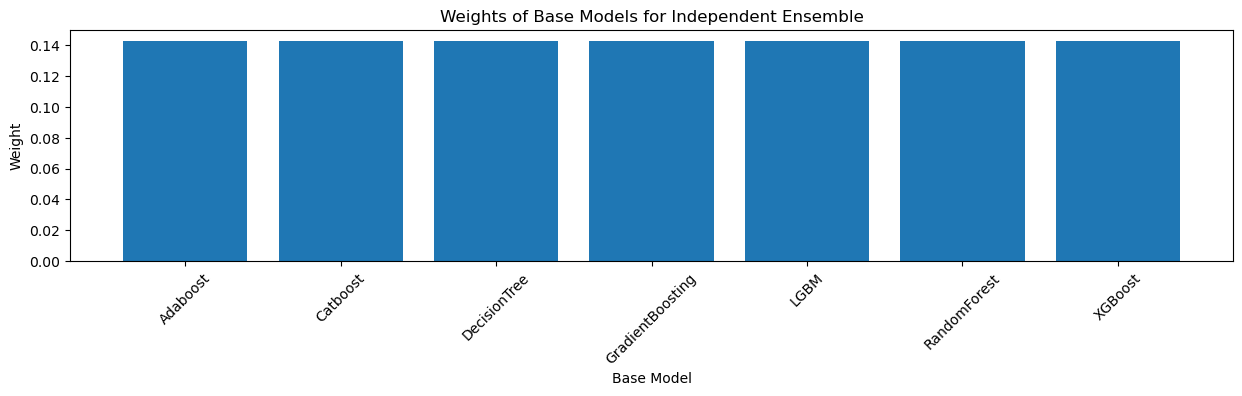

In [9]:
fig = plt.figure()
plt.rcParams["figure.figsize"] = (14,3)

model_names = ['Adaboost', 'Catboost', 'DecisionTree','GradientBoosting','LGBM','RandomForest','XGBoost']
fin_weights = [ 0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.14285714,
       0.14285714, 0.14285714]
plt.bar(model_names, weights)
plt.title("Weights of Base Models for Independent Ensemble")
plt.xticks(rotation=45)
plt.xlabel("Base Model")
plt.ylabel("Weight")
plt.show()

In [12]:
np.unique(weighted_prediction)

array([0.        , 0.14285714, 0.28571429, 0.42857143, 0.57142857,
       0.71428571, 0.85714286, 1.        ])

In [13]:
arr = np.where(weighted_prediction > 0.5, 1, 0)

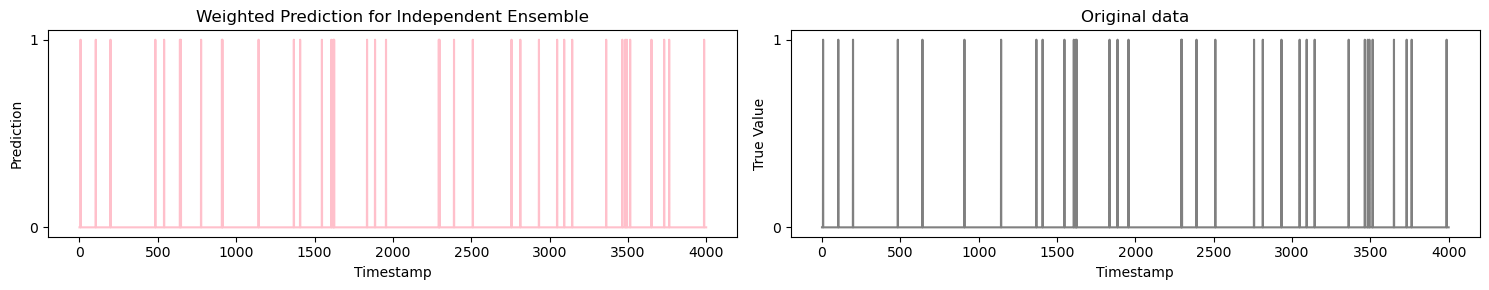

<Figure size 1100x300 with 0 Axes>

In [14]:
fig = plt.figure()
plt.rcParams["figure.figsize"] = (11,3)

# First plot
plt.subplot(1,2,1)
plt.title("Weighted Prediction for Independent Ensemble")
plt.plot(np.arange(len(arr[19000:23000])),arr[19000:23000],color="pink")
plt.xlabel("Timestamp")
plt.ylabel("Prediction")
plt.yticks([0.0, 1.0])

# Second plot
plt.subplot(1,2,2)
plt.title("Original data")
plt.plot(np.arange(len(y_test[19000:23000])),y_test[19000:23000],color="grey")
plt.xlabel("Timestamp")
plt.ylabel("True Value")
plt.yticks([0.0, 1.0])

plt.tight_layout()
plt.show()
plt.savefig('Independent_ensemble.png')

87.0


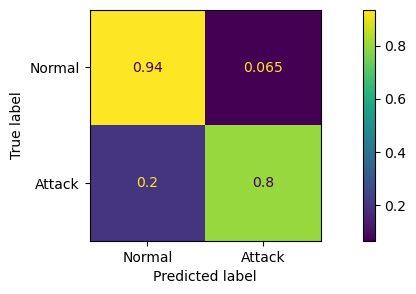

In [15]:
model_cm =confusion_matrix(y_test, arr,normalize='true')
# print(round(accuracy_score(y_test, arr),2)*100)
y_acc = accuracy_score(y_test, arr)
y_f1score = f1_score(y_test, arr)
y_recall = recall_score(y_test, arr)
y_bal = balanced_accuracy_score(y_test, arr)
print(round(balanced_accuracy_score(y_test, arr),2)*100)

disp = ConfusionMatrixDisplay(confusion_matrix=model_cm, display_labels = ["Normal","Attack"])
disp.plot()
# plt.savefig(f'{type(model).__name__}.png')

In [16]:
print(classification_report(y_test,arr))

              precision    recall  f1-score   support

         0.0       0.95      0.94      0.94   1560065
         1.0       0.74      0.80      0.77    363663

    accuracy                           0.91   1923728
   macro avg       0.85      0.87      0.86   1923728
weighted avg       0.91      0.91      0.91   1923728

